# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE emobase Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_emobase_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_all_opensmile_emobase_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_emobase_features = df_essentia_all_opensmile_emobase_features[df_essentia_all_opensmile_emobase_features.columns[1:]]

df_essentia_all_opensmile_emobase_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,2,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,...,1.121299,1.099986,-0.339925,-0.368315,-1.495692,0.139276,1.251933,1.502738,1.245620,1.382243
1,3,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,...,-0.751053,-0.671540,-0.187318,-0.107478,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
2,4,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,...,0.936125,0.958616,-0.382295,-0.388247,-0.643263,0.139276,0.393597,0.647609,0.390021,0.522072
3,5,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,...,1.053116,1.048412,-0.405301,-0.395619,-1.324591,0.139276,1.301805,1.331095,1.295332,1.320642
4,7,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,...,0.231374,0.371407,-0.344503,-0.336807,-0.465805,0.139276,0.487485,0.469588,0.483610,0.479259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,...,-0.969152,-0.970862,1.805891,1.493076,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
1740,1997,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,...,-1.527775,-2.071514,0.029865,-0.142352,0.713648,0.139276,-0.854889,-0.713601,-0.854482,-0.788262
1741,1998,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,...,-0.766593,-0.690273,-0.406636,-0.268314,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
1742,1999,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,...,-1.049113,-1.090194,0.711628,0.318666,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970


In [4]:
df_essentia_all_opensmile_emobase_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5502 columns):
 #     Column                                           Dtype  
---    ------                                           -----  
 0     song_id                                          int64  
 1     lowlevel.average_loudness                        float64
 2     lowlevel.barkbands_crest.dmean                   float64
 3     lowlevel.barkbands_crest.dmean2                  float64
 4     lowlevel.barkbands_crest.dvar                    float64
 5     lowlevel.barkbands_crest.dvar2                   float64
 6     lowlevel.barkbands_crest.max                     float64
 7     lowlevel.barkbands_crest.mean                    float64
 8     lowlevel.barkbands_crest.median                  float64
 9     lowlevel.barkbands_crest.min                     float64
 10    lowlevel.barkbands_crest.stdev                   float64
 11    lowlevel.barkbands_crest.var                     flo

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_emobase_whole = pd.merge(df_essentia_all_opensmile_emobase_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_emobase_whole = df_essentia_all_opensmile_emobase_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_emobase_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,valence_mean_mapped,arousal_mean_mapped
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,-0.339925,-0.368315,-1.495692,0.139276,1.251933,1.502738,1.245620,1.382243,-0.475,-0.500
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.187318,-0.107478,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970,-0.375,-0.425
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,-0.382295,-0.388247,-0.643263,0.139276,0.393597,0.647609,0.390021,0.522072,0.175,0.125
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,-0.405301,-0.395619,-1.324591,0.139276,1.301805,1.331095,1.295332,1.320642,-0.150,0.075
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,-0.344503,-0.336807,-0.465805,0.139276,0.487485,0.469588,0.483610,0.479259,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,1.805891,1.493076,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970,-0.275,0.225
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,0.029865,-0.142352,0.713648,0.139276,-0.854889,-0.713601,-0.854482,-0.788262,0.075,-0.275
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.406636,-0.268314,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970,0.350,0.300
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,0.711628,0.318666,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_emobase_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,0.568151,-0.495162,-0.392697,-0.744706,-0.546485,-0.870470,-0.239716,-0.144909,-0.751646,-0.806035,...,1.121299,1.099986,-0.339925,-0.368315,-1.495692,0.139276,1.251933,1.502738,1.245620,1.382243
1,-1.189985,-1.329502,-1.219457,-0.832461,-0.787198,1.027719,1.839969,1.739902,0.983723,0.411352,...,-0.751053,-0.671540,-0.187318,-0.107478,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
2,0.650480,-0.120976,-0.098623,-0.270405,-0.093387,-1.198606,-0.493636,-0.348739,-0.673459,-0.913741,...,0.936125,0.958616,-0.382295,-0.388247,-0.643263,0.139276,0.393597,0.647609,0.390021,0.522072
3,0.304588,-0.253761,-0.268728,-0.555905,-0.502125,0.225857,-0.133929,-0.197590,0.271977,-0.239829,...,1.053116,1.048412,-0.405301,-0.395619,-1.324591,0.139276,1.301805,1.331095,1.295332,1.320642
4,0.651505,-0.965369,-1.022563,-0.383251,-0.509374,-0.011622,1.571188,1.686327,-0.514739,-0.630103,...,0.231374,0.371407,-0.344503,-0.336807,-0.465805,0.139276,0.487485,0.469588,0.483610,0.479259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.675713,1.006280,1.063360,0.713243,0.633269,-0.779093,-0.607815,-0.681665,-0.013183,-0.518090,...,-0.969152,-0.970862,1.805891,1.493076,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
1740,0.683125,-0.291635,-0.136966,-0.549051,-0.394859,-1.571368,-0.677912,-0.561040,-0.216045,-0.915896,...,-1.527775,-2.071514,0.029865,-0.142352,0.713648,0.139276,-0.854889,-0.713601,-0.854482,-0.788262
1741,0.291013,0.225089,0.192632,-0.015061,-0.102338,-0.223639,-0.920913,-0.808273,-1.243963,-0.577341,...,-0.766593,-0.690273,-0.406636,-0.268314,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970
1742,0.577845,0.026765,0.244953,-0.602676,-0.436818,-1.339357,-0.815125,-0.667085,0.293630,-1.528391,...,-1.049113,-1.090194,0.711628,0.318666,0.914759,0.139276,-0.854889,-0.915349,-0.854482,-0.889970


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [31]:
num_epochs = 169

Set a random seed to ensure consistent initial weights of the neural network

In [32]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [34]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 5501])


Training loop

In [35]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [36]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5566997831262982
Epoch 2, Loss: 0.556077826567521
Epoch 3, Loss: 0.555834752366496
Epoch 4, Loss: 0.5548658755764556
Epoch 5, Loss: 0.5523141672286869
Epoch 6, Loss: 0.5469287845866163
Epoch 7, Loss: 0.5361917043001502
Epoch 8, Loss: 0.5191750416710333
Epoch 9, Loss: 0.5205978974045988
Epoch 10, Loss: 0.5040701074847973
Epoch 11, Loss: 0.49708656029667686
Epoch 12, Loss: 0.49490631849834404
Epoch 13, Loss: 0.4874876515951987
Epoch 14, Loss: 0.4749607622102517
Epoch 15, Loss: 0.4645907891819918
Epoch 16, Loss: 0.46020753895230665
Epoch 17, Loss: 0.45761105854457923
Epoch 18, Loss: 0.45059638042278755
Epoch 19, Loss: 0.4498783410709558
Epoch 20, Loss: 0.44673888661117545
Epoch 21, Loss: 0.4421957938558847
Epoch 22, Loss: 0.44045753137240456
Epoch 23, Loss: 0.4377333495580647
Epoch 24, Loss: 0.4337417934037137
Epoch 25, Loss: 0.4317317883638134
Epoch 26, Loss: 0.42841088780641917
Epoch 27, Loss: 0.4245773935074089
Epoch 28, Loss: 0.42293958210365684
Epoch 29, Loss: 0.4200

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [37]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 5501])


Generating scores

In [38]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [39]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.20527002698920027
Test R^2 score: 0.5393915350309932


True values (test set)

In [21]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 3.2167e-01,  3.0279e-01],
        [-2.0533e-01, -2.9944e-01],
        [ 3.9629e-01,  2.2347e-01],
        [ 9.2150e-02,  1.5040e-01],
        [ 3.1997e-02, -2.7861e-01],
        [-2.7605e-01, -3.2087e-01],
        [-7.8814e-02, -5.2963e-01],
        [ 9.2895e-02,  4.1000e-01],
        [-2.5942e-01, -4.5981e-01],
        [ 4.2183e-01,  2.8341e-01],
        [ 6.2332e-02, -4.5521e-02],
        [-3.8090e-01,  3.6238e-02],
        [ 3.3672e-02, -5.1967e-01],
        [ 1.7449e-01,  2.6128e-01],
        [ 8.6205e-02,  1.9332e-01],
        [-2.3404e-01, -2.7958e-01],
        [-5.0985e-01, -3.1568e-01],
        [-1.2203e-01, -2.8870e-01],
        [ 6.2796e-03,  1.5215e-01],
        [-7.2900e-02, -5.2140e-01],
        [-6.1743e-01, -4.7937e-01],
        [-4.6318e-01, -5.2252e-01],
        [-5.2943e-01, -4.5984e-01],
        [ 1.9785e-01,  3.0358e-01],
        [-1.9632e-01,  1.6505e-01],
        [ 2.5640e-01, -1.4620e-01],
        [ 2.6113e-01,  4.7912e-01],
        [ 7.8924e-02,  1.974

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5566997831262982
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3037018017241977
Test R^2 score: -0.005336084578183686
Num of epochs: 2
Epoch 1, Loss: 0.5566997831262982
Epoch 2, Loss: 0.556077826567521
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3027573586578653
Test R^2 score: 0.001185975967552766
Num of epochs: 3
Epoch 1, Loss: 0.5566997831262982
Epoch 2, Loss: 0.556077826567521
Epoch 3, Loss: 0.555834752366496
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30140154310039713
Test R^2 score: 0.010049138964243254
Num of epochs: 4
Epoch 1, Loss: 0.5566997831262982
Epoch 2, Loss: 0.556077826567521
Epoch 3, Loss: 0.555834752366496
Epoch 4, Loss: 0.5548658755764556
Training completed.
Training completed.
Testing model...
Test RMSE: 0.2986087601846519
Test R^2 score: 0.028129380827770056
Num of epochs: 5
Epoch 1, Loss: 0.5566997831262982
Epoch 2, Loss: 0.556077826567521
Epoch 3, Loss: 

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.005336084578183686,
 0.001185975967552766,
 0.010049138964243254,
 0.028129380827770056,
 0.0649625784511641,
 0.1362451589673978,
 0.2453574940988283,
 0.26886377812658935,
 0.329783425452566,
 0.338326837086391,
 0.3347536408824858,
 0.3631481347170902,
 0.4179583049864898,
 0.460316532090674,
 0.4676843639348302,
 0.4491380288869916,
 0.47928881374228305,
 0.4834059451743292,
 0.4847323174367106,
 0.4972555574945646,
 0.49787124267349275,
 0.4961151088556179,
 0.4992695804445173,
 0.5011827984017202,
 0.5105199263750629,
 0.5172405044864031,
 0.5109623716172005,
 0.5110177772476199,
 0.5130905413785483,
 0.511727503406856,
 0.5092447275953428,
 0.5158180618737571,
 0.5163103719805211,
 0.5133324188112849,
 0.5144314506289456,
 0.5056847478146503,
 0.5103498246458071,
 0.5060936635567717,
 0.5065534058878689,
 0.4895076078948686,
 0.5028785954512784,
 0.47037138192023326,
 0.5016892391520082,
 0.5051324928649078,
 0.489923584861435,
 0.48382436682921537,
 0.49772393434005435,
 0.

Plot the line graph

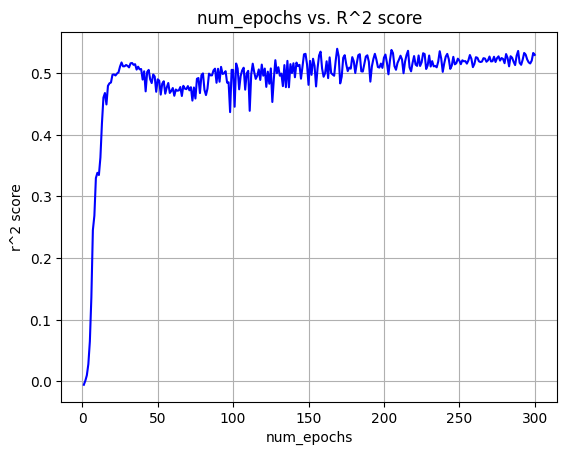

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5393915350309932
Corresponding RMSE: 0.20527002698920027
Corresponding num_epochs: 169
